# Exploratory Data Analysis (EDA) Notebook
This notebook prepares the data for use for the three models used in this experiment. The input is a dataset provided by HuggingFace and the output are CSV files saved to my Google Drive. The data will be fully preprocessed, filtered, shuffled, balanced and split.

[Data](https://huggingface.co/datasets/HoangCuongNguyen/CTI-to-MITRE-dataset)

## Install Libraries
- **Datasets** is a Hugging Face library that provides a simple way to access and load datasets.
- **TextAttack** is a Python library used for data augmentation.

In [1]:
!pip install datasets textattack

## Load Libraries
The following libraries are necessary to complete the EDA tasks in this notebook. Since the work on this project was completed entirely within Google Colab it was necessary to import the drive library to mount Google Drive, enabling easy access between the notebook and Google Drive stored files.

In [9]:
print("Versions of Imports")
print("-------------------")

# Data Analysis
import pandas as pd
print(f"pandas: {pd.__version__}")

# Data Augmentation
import textattack
from textattack.augmentation import EasyDataAugmenter

# Visualization
import matplotlib.pyplot as plt

# Hugging Face
from datasets import load_dataset

# SciKit Learn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Google Colab
from google.colab import drive

Versions of Imports
-------------------
pandas: 2.1.4


## Load Data
The dataset used for this project was found on Hugging Face's Datasets after keyword searching for 'MITRE'. This dataset contains 14.4k rows at 3.23 MB. A README.md file is present but did not have any additional information in it.

In [11]:
ds = load_dataset("HoangCuongNguyen/CTI-to-MITRE-dataset")

Generating train split:   0%|          | 0/14427 [00:00<?, ? examples/s]

In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 14427
    })
})

Looking at the first example, the data is contained as the value of a dictionary with the key 'text'.  

In [13]:
ds['train'][0]

{'text': '### Human:Find the techniques and ID from MITRE ATT&CK framework.,TrickBot has used macros in Excel documents to download and deploy the malware on the user’s machine.### Assistant: T1059: Command and Scripting Interpreter'}

Grab the data, throw it into a DataFrame and clean it up for use.

In [14]:
texts = ds['train']['text']
df = pd.DataFrame(texts, columns=['raw'])
df['text'] = df['raw'].str.replace('### Human:Find the techniques and ID from MITRE ATT&CK framework.,', '')
df['text'] = df['text'].str.replace('### Assistant:.*$', '', regex=True)
df['labels'] = df['raw'].str.extract(r'### Assistant: (.*)')
df['label_descriptions'] = df['labels'].str.extract(r'T\d+:(.*)')
df['labels'] = df['labels'].str.extract(r'(T\d+)')
del df['raw']
df.head()

,text,labels,label_descriptions
0,TrickBot has used macros in Excel documents to...,T1059,Command and Scripting Interpreter
1,SombRAT has the ability to use an embedded SOC...,T1090,Proxy
2,Silent Librarian has exfiltrated entire mailbo...,T1114,Email Collection
3,Azorult can collect a list of running processe...,T1057,Process Discovery
4,SeaDuke is capable of executing commands.,T1059,Command and Scripting Interpreter


There are 190 unique technique categories in the data set. At the time of this project, there are over 200 techniques in the matrix. This suggests that either the dataset is older or there has been some preprocessing done. After looking at some of the missing technques it appears that all of the 2023/2024 techniques are missing and some of the 2022 suggesting this dataset was curated sometime in early 2022. See the [Current Matrix](#current_matrix) cell below.

In [17]:
label_counts = df['labels'].value_counts()
label_counts.describe()

,count
count,190.000000
mean,75.931579
std,107.259467
min,4.000000
25%,16.250000
50%,34.000000
75%,88.750000
max,795.000000


Some techniques have extremely low counts while a few have very high counts. This skewness is displayed in the graph below.

In [18]:
def plot_label_counts(label_counts, no_xtick_labels=True):
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar', color='skyblue')
    plt.title('Histogram of Techniques')
    plt.ylabel('Frequency')
    plt.xlabel('Techniques')
    plt.xticks(rotation=90)
    if no_xtick_labels:
      plt.xticks([])
    else:
      plt.xticks(fontsize=6)
    plt.tight_layout()
    plt.show()

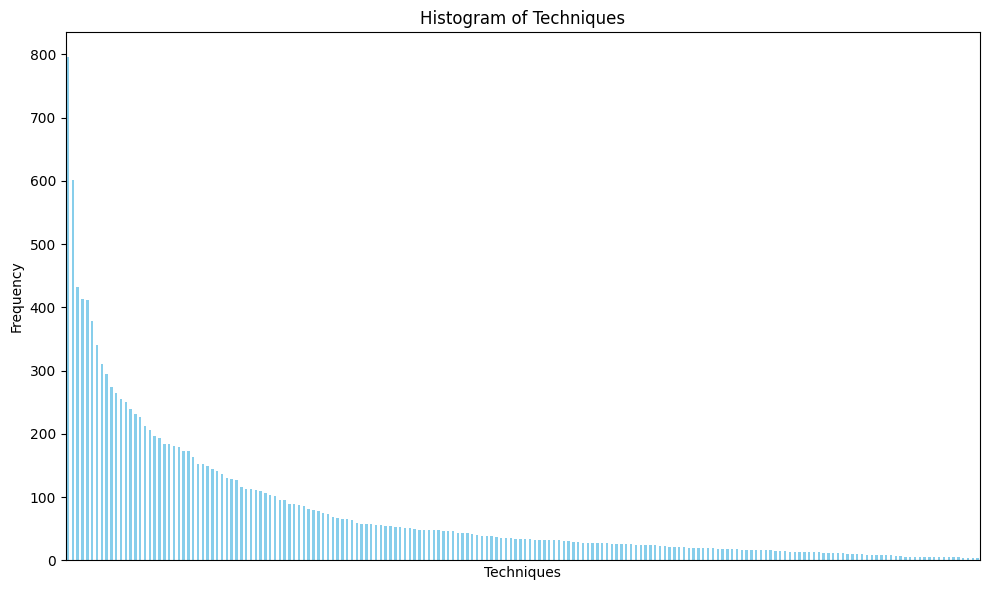

In [19]:
plot_label_counts(df['labels'].value_counts())

To handle this highly skewed (unbalanced) dataset I looked to the literature. Grigorescu et al. (see references in the paper) found the same issue when mapping CVEs to techniques. Their approach was to create a threshold and discard those below it. Using 100 as an abritary number we are left with 44 techniques. This is slightly lower than the TRAM number of 50 techniques MITRE used to fine-tune on.

In [21]:
labels_gt_100 = label_counts[label_counts > 100]
print(len(labels_gt_100))

44


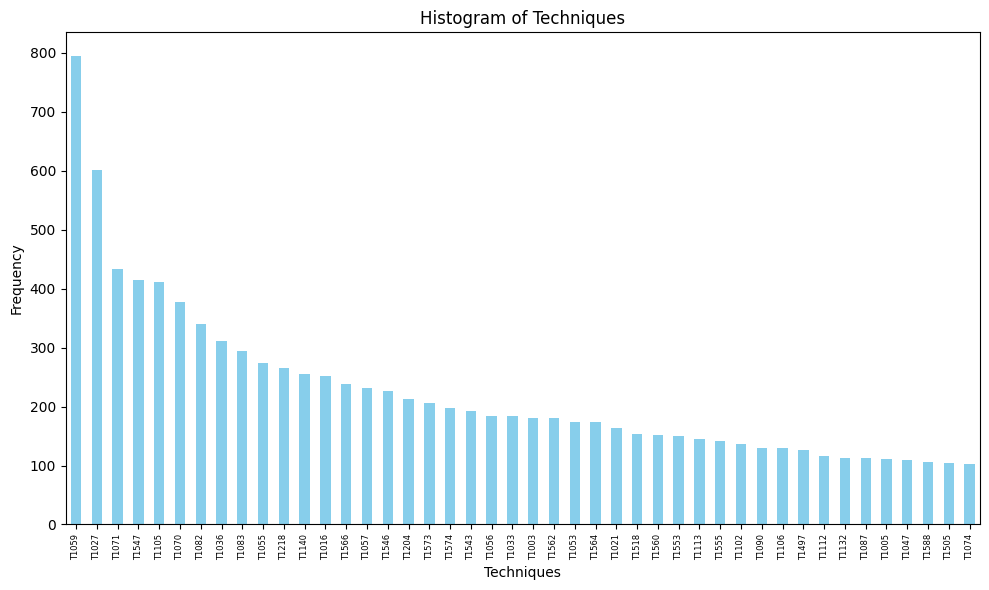

In [22]:
plot_label_counts(labels_gt_100, False)

In [23]:
labels_to_keep = label_counts[label_counts > 100].index
df_filtered = df[df['labels'].isin(labels_to_keep)]
df_filtered.head()

,text,labels,label_descriptions
0,TrickBot has used macros in Excel documents to...,T1059,Command and Scripting Interpreter
1,SombRAT has the ability to use an embedded SOC...,T1090,Proxy
3,Azorult can collect a list of running processe...,T1057,Process Discovery
4,SeaDuke is capable of executing commands.,T1059,Command and Scripting Interpreter
5,HOPLIGHT has the capability to harvest credent...,T1003,OS Credential Dumping


Futhermore, they used the TextAttack Framework to upsample minority (less than 200) classes using the data augmentation feature of the framework. By creating these synthetic records I was able to create a more balanced dataset.

In [24]:
threshold = 200
augmenter = EasyDataAugmenter()
augmented_data = []
label_counts = df_filtered['labels'].value_counts()
for label, count in label_counts.items():
    if count < threshold:
        label_df = df_filtered[df_filtered['labels'] == label]
        samples_needed = threshold - count
        for i in range(samples_needed):
            sample = label_df.sample(1, replace=True).iloc[0]
            augmented_texts = augmenter.augment(sample['text'])
            for augmented_text in augmented_texts:
                augmented_data.append({'text': augmented_text,
                                       'labels': label})
augmented_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([df_filtered, augmented_df])
balanced_df.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,labels,label_descriptions
0,TrickBot has used macros in Excel documents to...,T1059,Command and Scripting Interpreter
1,SombRAT has the ability to use an embedded SOC...,T1090,Proxy
3,Azorult can collect a list of running processe...,T1057,Process Discovery
4,SeaDuke is capable of executing commands.,T1059,Command and Scripting Interpreter
5,HOPLIGHT has the capability to harvest credent...,T1003,OS Credential Dumping


In [26]:
balanced_label_counts = balanced_df['labels'].value_counts()
labels_to_keep = balanced_label_counts[balanced_label_counts > 200].index
df_filtered_and_balanced = balanced_df[balanced_df['labels'].isin(labels_to_keep)]
df_filtered_and_balanced.head()

,text,labels,label_descriptions
0,TrickBot has used macros in Excel documents to...,T1059,Command and Scripting Interpreter
1,SombRAT has the ability to use an embedded SOC...,T1090,Proxy
3,Azorult can collect a list of running processe...,T1057,Process Discovery
4,SeaDuke is capable of executing commands.,T1059,Command and Scripting Interpreter
5,HOPLIGHT has the capability to harvest credent...,T1003,OS Credential Dumping


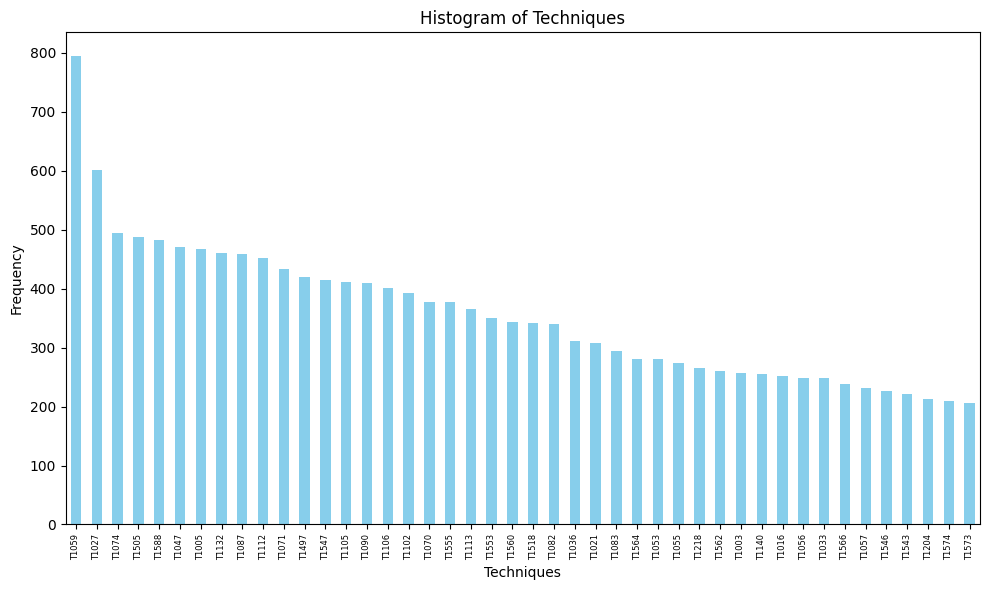

In [27]:
plot_label_counts(df_filtered_and_balanced['labels'].value_counts(), False)

We now have 44 classes all of which are over 200 samples.

In [28]:
adjusted_label_counts = df_filtered_and_balanced['labels'].value_counts()
adjusted_label_counts.describe()

,count
count,44.000000
mean,355.045455
std,119.339647
min,206.000000
25%,256.500000
50%,342.500000
75%,422.500000
max,795.000000


By downsampling the classes that have over 500 samples I was not only able to get a more balanaced dataset but also returned the number of samples closer to the original 14.4k to 15.2k.

In [29]:
df_filtered_and_balanced = pd.concat([
    resample(df_filtered_and_balanced[df_filtered_and_balanced['labels'] == label],
             n_samples=500,
             random_state=42)
    if count > 500 else df_filtered_and_balanced[df_filtered_and_balanced['labels'] == label]
    for label, count in label_counts.items()
])

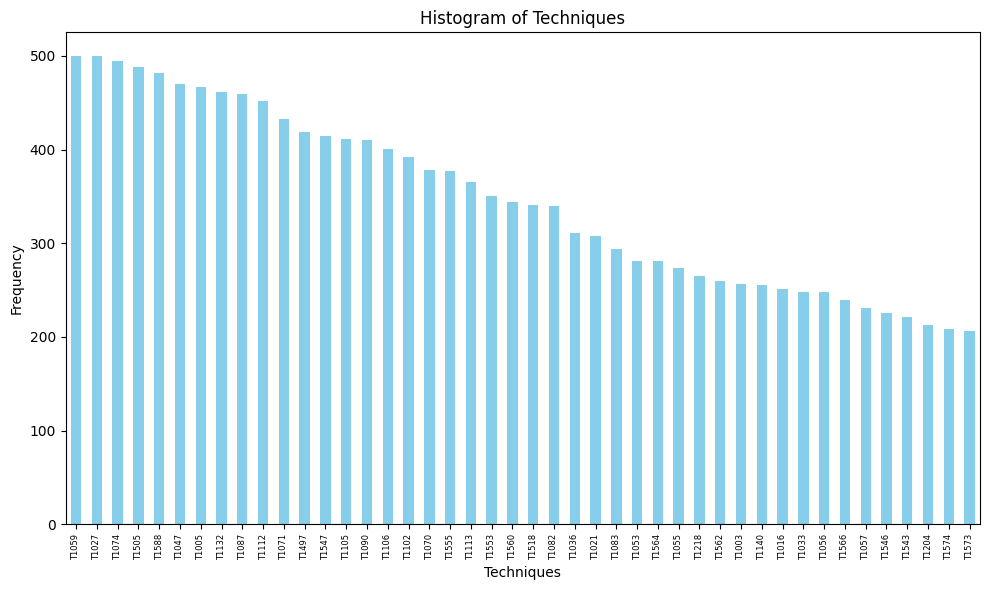

In [30]:
plot_label_counts(df_filtered_and_balanced['labels'].value_counts(), False)

In [31]:
final_counts = df_filtered_and_balanced['labels'].value_counts()
final_counts.describe()

,count
count,44.000000
mean,346.045455
std,96.063195
min,206.000000
25%,256.500000
50%,342.500000
75%,422.500000
max,500.000000


In [32]:
len(df_filtered_and_balanced)

15226

Below are examples of the original dataset entries followed by examples of the augmented dataset entries.

In [34]:
print(df_filtered_and_balanced[df_filtered_and_balanced['labels']=='T1087'].head(15).values)

[['OSInfo enumerates local and domain users USBferry can use net user to gather information about local accounts.'
  'T1087' ' Account Discovery']
 ['PUNCHBUGGY can gather user names.' 'T1087' ' Account Discovery']
 ['IcedID can query LDAP to identify additional users on the network to infect.'
  'T1087' ' Account Discovery']
 ['Sykipot may use net group "domain admins" /domain to display accounts in the "domain admins" permissions group and net localgroup "administrators" to list local system administrator group membership.'
  'T1087' ' Account Discovery']
 ['Elise executes net user after initial communication is made to the remote server.'
  'T1087' ' Account Discovery']
 ['MURKYTOP has the capability to retrieve information about users on remote hosts.'
  'T1087' ' Account Discovery']
 [' /etc/passwd ' 'T1087' ' Account Discovery']
 ['Sandworm Team has used a tool to query Active Directory using LDAP, discovering information about usernames listed in AD.'
  'T1087' ' Account Discove

In [35]:
augmented_T1001 = df_filtered_and_balanced[(df_filtered_and_balanced['labels']=='T1087') & (df_filtered_and_balanced['label_descriptions'].isna())]
print(augmented_T1001.head(15).values)

[['Chimera has used net user for score discovery.' 'T1087' nan]
 ['has used net user for account discovery.' 'T1087' nan]
 ['Chimera has profits used net user for account discovery.' 'T1087' nan]
 ['Chimera has used discovery user for account net.' 'T1087' nan]
 ['APT32 enumerated administrative users and DC servers using the commands localgroup net administrators and net group "Domain Controllers" /domain.'
  'T1087' nan]
 ['APT32 enumerated web administrative users and DC servers using the commands net localgroup administrators and net group "Domain Controllers" /domain.'
  'T1087' nan]
 ['APT32 enumerated administrative users and DC servers using commands net localgroup administrators and net group "Domain Controllers" /domain.'
  'T1087' nan]
 ['APT32 itemise administrative users and DC servers using the commands net localgroup administrators and net group "Domain Controllers" /domain.'
  'T1087' nan]
 ['Agent Tesla can collect account information the victim’s machine.'
  'T1087' n

**Original:**
Chimera has used net user for account discovery.

**Replacement:** Chimera has used net user for _score_ discovery.

**Removal:** has used net user for account discovery.

**Insertion:** Chimera has _profits_ used net user for account discovery.

**Swap:** Chimera has used _discovery_ user for account _net_.

Label_description was dropped to remove the nan's from the concatenated augmented entries.

In [36]:
df_filtered_and_balanced = df_filtered_and_balanced.drop(columns=['label_descriptions'])

In [37]:
df_filtered_and_balanced.head()

,text,labels
1999,"Via WMI (winmgmt), the JavaScript or VBscript ...",T1059
7999,RDAT has executed commands using cmd.exe /c.,T1059
4858,HOMEFRY uses a command-line interface.,T1059
2051,!CMD Trojan executes a command prompt command,T1059
1470,Machete is written in Python and is used in co...,T1059


Reshuffle before exporting.

In [38]:
df_filtered_and_balanced = df_filtered_and_balanced.sample(frac=1).reset_index(drop=True)

Experiencing an error with the BERT tokenizer. The error appears to have an issue with the form of the input. However, I have verified that everything in the DataFrame is of type string and I've also removed all single and double qoutes in case they were causing issue.

Verified everything in the DataFrame is of type string, all single and double qoutes have been removed and there are no empty strings.

In [39]:
non_string_df = df_filtered_and_balanced.applymap(lambda x: not isinstance(x, str))
rows_with_non_string = df_filtered_and_balanced[non_string_df.any(axis=1)]
print(rows_with_non_string)

Empty DataFrame
Columns: [text, labels]
Index: []


<ipython-input-39-f562a6c2cb34>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_string_df = df_filtered_and_balanced.applymap(lambda x: not isinstance(x, str))


In [40]:
contains_double_qoute = df_filtered_and_balanced['text'].str.contains(r'"').sum()
contains_single_qoute = df_filtered_and_balanced['text'].str.contains(r"'").sum()
print(f"{contains_double_qoute=}\t{contains_single_qoute=}")

contains_double_qoute=251	contains_single_qoute=789


In [41]:
df_filtered_and_balanced['text'] = df_filtered_and_balanced['text'].str.replace(r"'", "", regex=True)
df_filtered_and_balanced['text'] = df_filtered_and_balanced['text'].str.replace(r'"', "", regex=True)

In [42]:
contains_double_qoute = df_filtered_and_balanced['text'].str.contains(r'"').sum()
contains_single_qoute = df_filtered_and_balanced['text'].str.contains(r"'").sum()
print(f"{contains_double_qoute=}\t{contains_single_qoute=}")

contains_double_qoute=0	contains_single_qoute=0


In [43]:
empty_string_df = df_filtered_and_balanced.applymap(lambda x: isinstance(x, str) and x.strip() == '')
rows_with_empty_strings = df_filtered_and_balanced[empty_string_df.any(axis=1)]
print(rows_with_empty_strings)

Empty DataFrame
Columns: [text, labels]
Index: []


<ipython-input-43-da238d6f8de5>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_string_df = df_filtered_and_balanced.applymap(lambda x: isinstance(x, str) and x.strip() == '')


## Save Data and Splits
The data is saved to my Google Drive in the same directory as my notebooks. The preprocessed data is saved as a CSV to be used in the model notebooks.

In [44]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/balanced_data.csv'
df_filtered_and_balanced.to_csv(file_path, index=False)

Mounted at /content/drive


MITRE used an 80/20 split. I went further and split test into test and validation sets at 10% of the original dataset.

In [45]:
train_df, temp_df = train_test_split(df_filtered_and_balanced,
                                     test_size=0.2,
                                     random_state=34) # Go Bears!
val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,
                                   random_state=34)

len(train_df), len(val_df), len(test_df)

(12180, 1523, 1523)

In [46]:
train_df[:2]

,text,labels
5761,Penquin can encrypt communications using the B...,T1573
8919,Kimsuky to used modified versions of open sour...,T1505


In [47]:
train_df.to_csv('/content/drive/My Drive/Colab Notebooks/train_df.csv', index=False)
val_df.to_csv('/content/drive/My Drive/Colab Notebooks/val_df.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/test_df.csv', index=False)

---
Everything below this line was used to explore the data and did not have any impact on the final preprocessed data files.
---

The following dictionary has tactics for keys and a corresponding list of techniques for values. This dictionary was created with today's (7/7/2024) current matrix.

<a id='current_matrix'></a>

In [ ]:
mitre_mapping = {'TA0043': ['T1595', 'T1592', 'T1589', 'T1590', 'T1591', 'T1598', 'T1597', 'T1596', 'T1593', 'T1594'],
                 'TA0042': ['T1650', 'T1583', 'T1586', 'T1584', 'T1587', 'T1585', 'T1588', 'T1608'],
                 'TA0001': ['T1659', 'T1189', 'T1190', 'T1133', 'T1200', 'T1566', 'T1091', 'T1195', 'T1199', 'T1078'],
                 'TA0002': ['T1651', 'T1059', 'T1609', 'T1610', 'T1203', 'T1559', 'T1106', 'T1053', 'T1648', 'T1129', 'T1072', 'T1569', 'T1204', 'T1047'],
                 'TA0003': ['T1098', 'T1197', 'T1547', 'T1037', 'T1176', 'T1554', 'T1136', 'T1543', 'T1546', 'T1133', 'T1574', 'T1525', 'T1556', 'T1137', 'T1653', 'T1542', 'T1053', 'T1505', 'T1205', 'T1078'],
                 'TA0004': ['T1548', 'T1134', 'T1098', 'T1547', 'T1037', 'T1543', 'T1484', 'T1611', 'T1546', 'T1068', 'T1547', 'T1055', 'T1053', 'T1078'],
                 'TA0005': ['T1548', 'T1134', 'T1197', 'T1612', 'T1622', 'T1140', 'T1610', 'T1006', 'T1484', 'T1480', 'T1211', 'T1222', 'T1564', 'T1574', 'T1562', 'T1656', 'T1070', 'T1202', 'T1036', 'T1556', 'T1578', 'T1112', 'T1601', 'T1599', 'T1027', 'T1647', 'T1542', 'T1055', 'T1620', 'T1207', 'T1014', 'T1553', 'T1218', 'T1216', 'T1221', 'T1205', 'T1127', 'T1535', 'T1550', 'T1078', 'T1497', 'T1600', 'T1220'],
                 'TA0006': ['T1557', 'T1110', 'T1555', 'T1212', 'T1187', 'T1606', 'T1056', 'T1556', 'T1111', 'T1621', 'T1040', 'T1003', 'T1528', 'T1649', 'T1558', 'T1539', 'T1552'],
                 'TA0007': ['T1087', 'T1010', 'T1217', 'T1580', 'T1538', 'T1526', 'T1619', 'T1613', 'T1622', 'T1652', 'T1482', 'T1083', 'T1615', 'T1654', 'T1046', 'T1135', 'T1040', 'T1201', 'T1120', 'T1069', 'T1057', 'T1012', 'T1018', 'T1518', 'T1082', 'T1614', 'T1016', 'T1049', 'T1033', 'T1007', 'T1124', 'T1497'],
                 'TA0008': ['T1210', 'T1534', 'T1570', 'T1563', 'T1021', 'T1091', 'T1072', 'T1080', 'T1550'],
                 'TA0009': ['T1557', 'T1560', 'T1123', 'T1119', 'T1185', 'T1115', 'T1530', 'T1602', 'T1213', 'T1005', 'T1039', 'T1025', 'T1074', 'T1114', 'T1056', 'T1113', 'T1125'],
                 'TA0011': ['T1071', 'T1092', 'T1659', 'T1132', 'T1001', 'T1568', 'T1573', 'T1008', 'T1665', 'T1105', 'T1104', 'T1095', 'T1571', 'T1572', 'T1090', 'T1219', 'T1205', 'T1102'],
                 'TA0010': ['T1020', 'T1030', 'T1048', 'T1041', 'T1011', 'T1052', 'T1567', 'T1029', 'T1537'],
                 'TA0040': ['T1531', 'T1485', 'T1486', 'T1565', 'T1491', 'T1561', 'T1499', 'T1657', 'T1495', 'T1490', 'T1498', 'T1496', 'T1489', 'T1529']
}

There are 235 techniques listed in the matrix.

In [ ]:
def count_values(data):
    counts = {}
    for key, values in data.items():
        counts[key] = len(values)
    return counts

counts = count_values(mitre_mapping)
print(counts)
print(sum(counts.values()))

{'TA0043': 10, 'TA0042': 8, 'TA0001': 10, 'TA0002': 14, 'TA0003': 20, 'TA0004': 14, 'TA0005': 43, 'TA0006': 17, 'TA0007': 32, 'TA0008': 9, 'TA0009': 17, 'TA0011': 18, 'TA0010': 9, 'TA0040': 14}
235


In [ ]:
def filter_mitre_mapping(df, mitre_mapping):
    valid_labels = set(df['labels'])
    removed_labels = {}

    for tactic, techniques in mitre_mapping.items():
        original_techniques = set(techniques)
        filtered_techniques = [tech for tech in techniques if tech in valid_labels]
        removed = original_techniques - set(filtered_techniques)

        if removed:
            removed_labels[tactic] = list(removed)
        mitre_mapping[tactic] = filtered_techniques

    return mitre_mapping, removed_labels

The following Techniques were not in the dataset and have been filtered out of the the MITRE mapping data structure.

- T1650: 10 March 2023
- T1659: 01 September 2023
- T1651: 13 March 2023
- T1648: 27 May 2022
- T1653: 05 June 2023
- ...


In [ ]:
filtered_mapping, removed_labels = filter_mitre_mapping(df, mitre_mapping)

print("Filtered MITRE Mapping:")
print(filtered_mapping)
print("\nRemoved Labels:")
print(removed_labels)

Filtered MITRE Mapping:
{'TA0043': ['T1595', 'T1592', 'T1589', 'T1590', 'T1591', 'T1598', 'T1597', 'T1596', 'T1593', 'T1594'], 'TA0042': ['T1583', 'T1586', 'T1584', 'T1587', 'T1585', 'T1588', 'T1608'], 'TA0001': ['T1189', 'T1190', 'T1133', 'T1200', 'T1566', 'T1091', 'T1195', 'T1199', 'T1078'], 'TA0002': ['T1059', 'T1609', 'T1610', 'T1203', 'T1559', 'T1106', 'T1053', 'T1129', 'T1072', 'T1569', 'T1204', 'T1047'], 'TA0003': ['T1098', 'T1197', 'T1547', 'T1037', 'T1176', 'T1554', 'T1136', 'T1543', 'T1546', 'T1133', 'T1574', 'T1525', 'T1556', 'T1137', 'T1542', 'T1053', 'T1505', 'T1205', 'T1078'], 'TA0004': ['T1548', 'T1134', 'T1098', 'T1547', 'T1037', 'T1543', 'T1484', 'T1611', 'T1546', 'T1068', 'T1547', 'T1055', 'T1053', 'T1078'], 'TA0005': ['T1548', 'T1134', 'T1197', 'T1612', 'T1140', 'T1610', 'T1006', 'T1484', 'T1480', 'T1211', 'T1222', 'T1564', 'T1574', 'T1562', 'T1070', 'T1202', 'T1036', 'T1556', 'T1578', 'T1112', 'T1601', 'T1599', 'T1027', 'T1542', 'T1055', 'T1620', 'T1207', 'T1014', '

This filtering removed 16 techniques.

In [ ]:
filtered_counts = count_values(filtered_mapping)
print(filtered_counts)
print(sum(filtered_counts.values()))

{'TA0043': 10, 'TA0042': 7, 'TA0001': 9, 'TA0002': 12, 'TA0003': 19, 'TA0004': 14, 'TA0005': 40, 'TA0006': 15, 'TA0007': 29, 'TA0008': 9, 'TA0009': 17, 'TA0011': 16, 'TA0010': 9, 'TA0040': 13}
219


There are 25 techniques that are contained in more than one tactic. Taking the first technique as an example, T1133 (External Remote Services) exists in both TA0003 (Persistence) and TA0001 (Initial Access).

In [ ]:
def find_duplicates(data):
    from collections import Counter
    all_values = [value for values in data.values() for value in values]
    value_counts = Counter(all_values)
    duplicates = [value for value, count in value_counts.items() if count > 1]
    return duplicates

duplicates = find_duplicates(filtered_mapping)
print(duplicates)
print(len(duplicates))

['T1133', 'T1091', 'T1078', 'T1610', 'T1053', 'T1072', 'T1098', 'T1197', 'T1547', 'T1037', 'T1543', 'T1546', 'T1574', 'T1556', 'T1542', 'T1205', 'T1548', 'T1134', 'T1484', 'T1055', 'T1550', 'T1497', 'T1557', 'T1056', 'T1040']
25


In [ ]:
T1133_df = df[df['labels'] == 'T1133']
top_5 = T1133_df.head(5)
top_5

,raw,text,labels,label_descriptions
369,### Human:Find the techniques and ID from MITR...,Doki was executed through an open Docker daemo...,T1133,External Remote Services
582,### Human:Find the techniques and ID from MITR...,Kinsing was executed in an Ubuntu container de...,T1133,External Remote Services
592,### Human:Find the techniques and ID from MITR...,"APT34 uses remote services such as VPN, Citrix...",T1133,External Remote Services
1506,### Human:Find the techniques and ID from MITR...,Sandworm Team has used Dropbear SSH with a har...,T1133,External Remote Services
1913,### Human:Find the techniques and ID from MITR...,"OilRig uses remote services such as VPN, Citri...",T1133,External Remote Services
